<a href="https://colab.research.google.com/github/Thofa90/Natural-Language-Processing-with-Disaster-Tweets/blob/main/NLP_Project_Twitter_Disaster_TextClassification_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Importing Libraries**

In [ ]:
# Importing necessary libraries
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation
import random  # for shuffling the data
import nltk
import re  # for handling regular expressions

from nltk.stem import WordNetLemmatizer  # for lemmatizing words
from nltk.corpus import stopwords  # for stop word removal
from nltk.tokenize import word_tokenize  # for tokenizing sentences into words
nltk.download('punkt_tab')  # Downloads the 'punkt' tokenizer table used for tokenization of text into sentences or words

# Downloading necessary NLTK resources
nltk.download('stopwords')  # List of common stop words in English
nltk.download('punkt')  # Pre-trained tokenizer models
nltk.download('wordnet')  # WordNet lemmatizer dataset

# Libraries for text feature extraction and model training
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text into numerical features (TF-IDF)
from sklearn.feature_extraction.text import CountVectorizer  # Convert text into numerical features (Count Vectorizer)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split  # Logistic regression for classification
from sklearn.svm import LinearSVC  # Support Vector Machines for classification

# Libraries for model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # For model evaluation metrics
from sklearn.model_selection import KFold, cross_val_score  # For cross-validation

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Step 2: Load & Preview the data**

The Sentence Polarity dataset contains 5,331 positive and 5,331 negative sentences. I'll load this dataset as .txt file and read it with pandas dataframe to prepare it for analysis. I am also giving new column name the text part as 'review' and creat a new column name 'label'. 'label' column has 0 for negetive review and 1 for positive review.

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Datasets/train.csv"

df = pd.read_csv(path)
print('datashape:',df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
datashape: (7613, 2)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# **Step 3: EDA**


##  1.Check Data Info & Null Values

In [ ]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
None

Missing values:
 text      0
target    0
dtype: int64


## 2.Class Distribution (Target Counts)

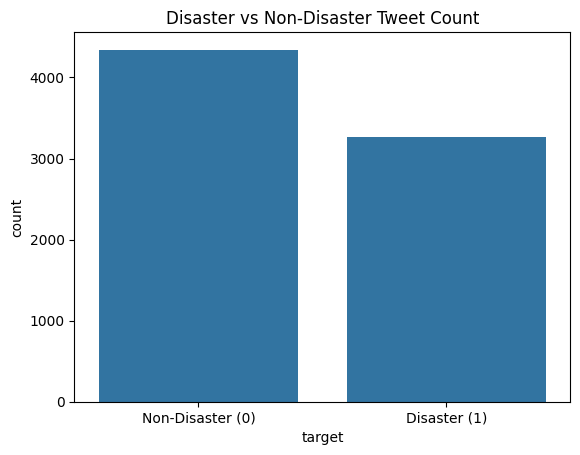

target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='target')
plt.title("Disaster vs Non-Disaster Tweet Count")
plt.xticks([0, 1], ['Non-Disaster (0)', 'Disaster (1)'])
plt.show()

# Percentage
print(df['target'].value_counts(normalize=True) * 100)

	•	The dataset is not perfectly balanced, but it’s not extremely imbalanced either.
	•	I can still consider:
	•	Using stratified splits to maintain this ratio during train/test split.
	•	Monitoring recall or F1-score during evaluation (not just accuracy).
	•	Optionally applying class weights in models (like class_weight='balanced' in LogisticRegression or fit() in Keras).

##  3.Tweet Length Distribution

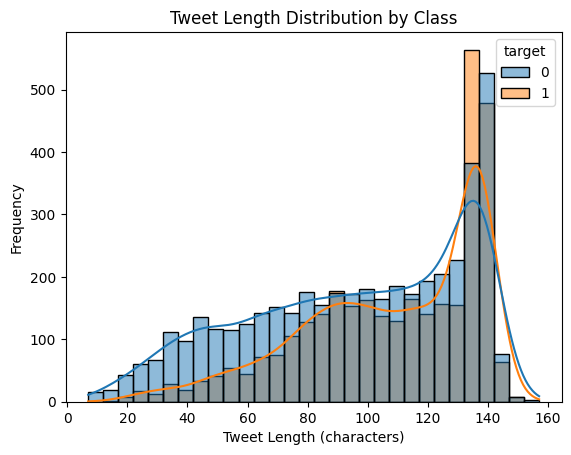

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df['text_length'] = df['text'].apply(len)

sns.histplot(data=df, x='text_length', hue='target', bins=30, kde=True)
plt.title("Tweet Length Distribution by Class")
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Frequency")
plt.show()

	• Implication: Most tweets are short-to-medium length, with fewer very long tweets.

	• I can extract tweet_length as a feature if using traditional ML models (e.g., Logistic Regression, XGBoost).

##  4.Most Frequent Words (Before Preprocessing)

Disaster Tweets Top Words: [('t', 2659), ('co', 2528), ('http', 2382), ('the', 1364), ('in', 1164), ('a', 935), ('of', 928), ('to', 757), ('and', 506), ('on', 420), ('for', 401), ('i', 387), ('s', 361), ('is', 352), ('at', 308), ('by', 278), ('from', 245), ('it', 240), ('that', 210), ('with', 192)]
Non-Disaster Tweets Top Words: [('t', 2540), ('co', 2212), ('http', 1927), ('the', 1913), ('i', 1391), ('a', 1265), ('to', 1192), ('and', 920), ('of', 902), ('in', 822), ('you', 757), ('is', 598), ('s', 549), ('my', 546), ('it', 539), ('for', 493), ('on', 440), ('that', 413), ('with', 380), ('this', 298)]


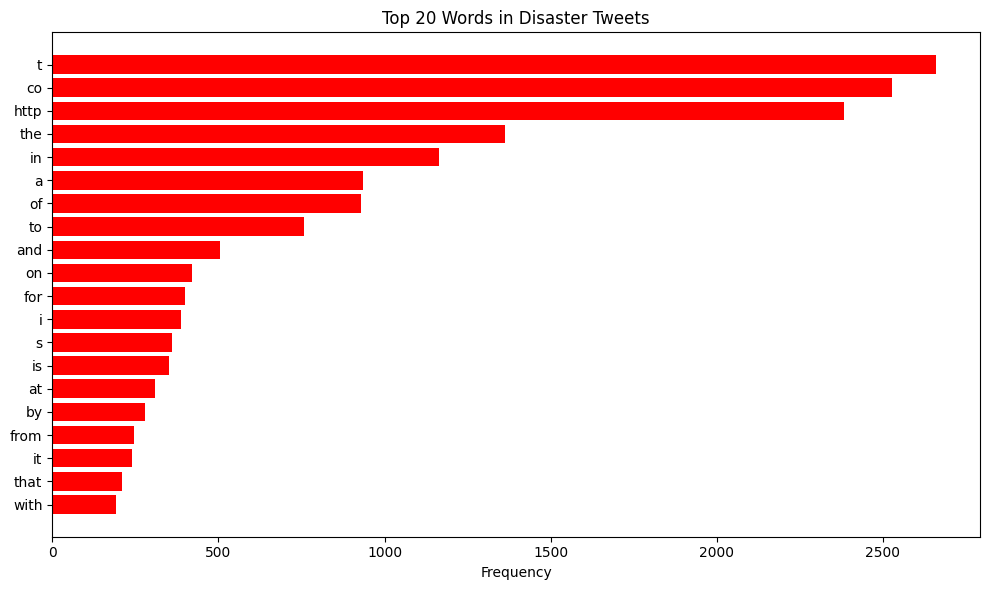

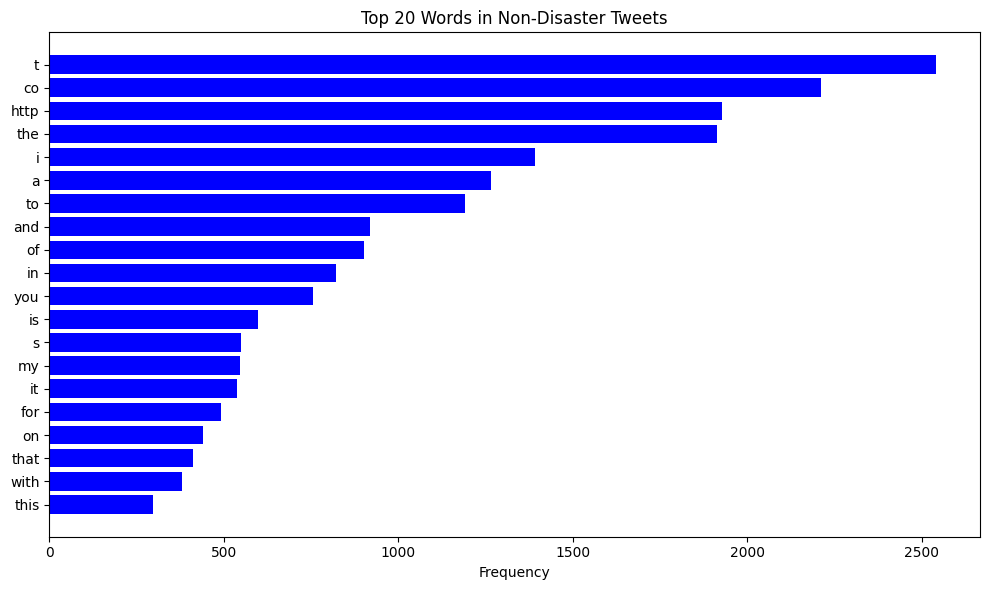

In [ ]:
from collections import Counter
import re
import matplotlib.pyplot as plt

def get_words(texts):
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())  # Extract words and convert to lowercase
        all_words.extend(words)
    return all_words

# Get word lists
disaster_words = get_words(df[df['target'] == 1]['text'])
non_disaster_words = get_words(df[df['target'] == 0]['text'])

# Top 20 most common words
disaster_counts = Counter(disaster_words).most_common(20)
non_disaster_counts = Counter(non_disaster_words).most_common(20)
# Top 20 words
print("Disaster Tweets Top Words:", Counter(disaster_words).most_common(20))
print("Non-Disaster Tweets Top Words:", Counter(non_disaster_words).most_common(20))

# Plotting
def plot_top_words(word_counts, title, color):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 6))
    plt.barh(words[::-1], counts[::-1], color=color)  # Horizontal bar chart
    plt.title(title)
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_top_words(disaster_counts, "Top 20 Words in Disaster Tweets", "red")
plot_top_words(non_disaster_counts, "Top 20 Words in Non-Disaster Tweets", "blue")

1.	Top Words Are Mostly Noise

	•	Words like “t”, “co”, “http”, “the”, “a”, and “in” appear in both classes.

	•	These are stop words or Twitter-specific artifacts (e.g., URL remnants like http, co, t from shortened links).

	•	These words don’t carry sentiment or semantic meaning, making them poor features for classification.

2.	Little Discriminative Power

	•	The frequency distributions for both classes are very similar, with high overlap in the top words.

	•	This suggests that removing common words is important to avoid noise and help the model focus on more meaningful words.

3.	Need for Cleaning

	•	The presence of http, co, and t indicates that URL cleaning is necessary.
  
	•	Additionally, removal of stopwords and lemmatization can help highlight more distinctive tokens.

## 5.Average Words per Class

In [ ]:
df.groupby('target')['text_length'].mean()

,text_length
target,
0,95.706817
1,108.113421


🔍 Interpretation:

	•	Disaster tweets tend to be longer on average than non-disaster tweets.
	•	This may indicate that people provide more context, detail, or urgency when tweeting about real disasters.
	•	In contrast, non-disaster tweets might be more casual, humorous, or general, resulting in shorter length.

## 6.Word Clouds

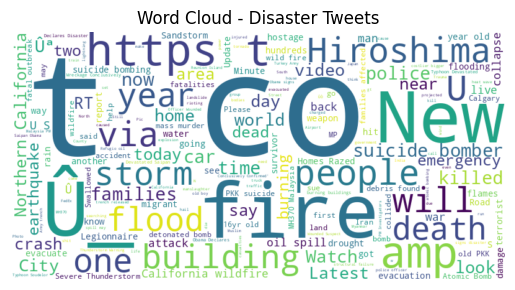

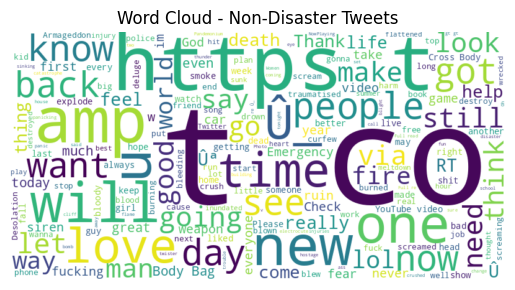

In [ ]:
from wordcloud import WordCloud

text_1 = " ".join(df[df['target'] == 1]['text'])
text_0 = " ".join(df[df['target'] == 0]['text'])

# Disaster
wc1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Disaster Tweets")
plt.show()

# Non-Disaster
wc0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
plt.imshow(wc0, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Non-Disaster Tweets")
plt.show()

🔍 Key Observations:

	High-frequency terms:
	•	“fire,” “flood,” “storm,” “death,” “bomb,” “crash,” “killed,” “suicide” — strongly indicate disaster contexts.
	•	“people,” “families,” “home,” “emergency” — show human impact and urgency.
	Named entities:
	•	Locations like “New,” “Hiroshima,” “California,” “City,” “Iran” appear, suggesting specific disaster areas are often named.
	Common noise tokens:
	•	Terms like “t,” “co,” “amp,” “u” and URLs like “https” are artifacts of tweets (HTML encoding, links) and may need cleaning.

✅ Recommendation:

	•	Consider removing URL fragments and encoded tokens (co, amp, t, u) during preprocessing to improve model focus on meaningful terms.
	•	Words like “fire,” “storm,” “death” can be strong indicators for model learning.


## 7.Hashtags, Mentions, Links Frequency

In [ ]:
df['num_hashtags'] = df['text'].apply(lambda x: x.count('#'))
df['num_mentions'] = df['text'].apply(lambda x: x.count('@'))
df['num_links'] = df['text'].apply(lambda x: len(re.findall(r'http\S+', x)))

# Compare
df[['num_hashtags', 'num_mentions', 'num_links']].describe()

,num_hashtags,num_mentions,num_links
count,7613.000000,7613.000000,7613.000000
mean,0.446999,0.362406,0.620123
std,1.099841,0.720097,0.663930
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000
max,13.000000,8.000000,4.000000


✅ Implications:

•	Highly skewed features — many zeros, few high values → you may consider using them as binary indicators (has or not).

• Most tweets don’t have hashtags, but a few have many (up to 13).

• Mentions are also sparse, with 75% of tweets having none.

• Links are the most common, with at least one link in 50% of tweets.

•	Links are very common and may strongly correlate with news/disaster tweets.

•	Could be useful engineered features for classification models.


## 8.Examples of Ambiguous / Short Tweets

In [ ]:
print("Shortest tweets:")
print(df[df['text_length'] < 20][['text', 'target']].head(10))

print("\nLongest tweets:")
print(df[df['text_length'] > 200][['text', 'target']].head(10))

Shortest tweets:
                  text  target
15      What's up man?       0
16       I love fruits       0
17    Summer is lovely       0
18   My car is so fast       0
21   London is cool ;)       0
22         Love skiing       0
24            LOOOOOOL       0
27  Love my girlfriend       0
28           Cooool :)       0
29  Do you like pasta?       0

Longest tweets:
Empty DataFrame
Columns: [text, target]
Index: []


	1.	The dataset contains several very short tweets (< 20 characters) that are non-disaster and often ambiguous or generic (e.g., “I love fruits”, “What’s up man?”).
	2.	No tweets were found with length > 200 characters, indicating that most tweets are short and concise—typical for Twitter data.

 ## 9.Compare Overlapping Words

🔁 Common words in top 50 of both classes:
{'we', 'the', 'from', 'you', 'my', 'are', 'to', 't', 'as', 's', 'be', 'that', 'up', 'with', 'was', 'is', 'amp', 'but', 'http', 'on', 'it', 'https', 'i', 'this', 'for', 'at', 'have', 'a', 'by', 'co', 'of', 'û_', 'in', 'and'}


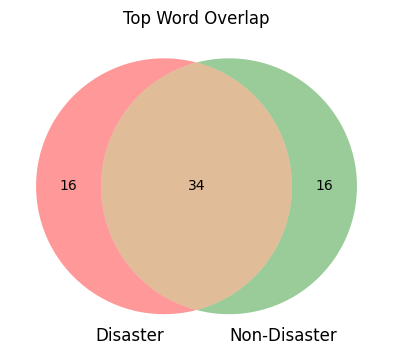

In [ ]:
from collections import Counter
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Get top N words
top_n = 50
disaster_words = get_words(df[df['target'] == 1]['text'])
non_disaster_words = get_words(df[df['target'] == 0]['text'])

top_disaster = set([word for word, _ in Counter(disaster_words).most_common(top_n)])
top_non_disaster = set([word for word, _ in Counter(non_disaster_words).most_common(top_n)])

# Find overlapping words
common_words = top_disaster & top_non_disaster

print(f"🔁 Common words in top {top_n} of both classes:")
print(common_words)

# Optional: Visualize with Venn diagram
plt.figure(figsize=(6, 4))
venn2([top_disaster, top_non_disaster], set_labels=("Disaster", "Non-Disaster"))
plt.title("Top Word Overlap")
plt.show()

	•	The Venn diagram shows that 34 out of the top 50 words are common between both disaster and non-disaster tweet classes.
	•	These overlapping words are mostly stopwords, generic terms, or tokens like 'amp', 'http', 'co', 't', etc., which do not carry strong sentiment or topic signals.
	•	Only 16 words are unique to each class, suggesting limited discriminative power from top words alone.
	•	This insight highlights the importance of:
	•	Removing or down-weighting common/neutral tokens (e.g., with TF-IDF or stopword filtering).
	•	Exploring contextual patterns (e.g., n-grams or embeddings) instead of relying solely on word frequency.
  

# **Step 4: Data Preprocessing**

In [ ]:
df.head(10)

,text,target,text_length,num_hashtags,num_mentions,num_links
0,Our Deeds are the Reason of this #earthquake M...,1,69,1,0,0
1,Forest fire near La Ronge Sask. Canada,1,38,0,0,0
2,All residents asked to 'shelter in place' are ...,1,133,0,0,0
3,"13,000 people receive #wildfires evacuation or...",1,65,1,0,0
4,Just got sent this photo from Ruby #Alaska as ...,1,88,2,0,0
5,#RockyFire Update => California Hwy. 20 closed...,1,110,3,0,0
6,#flood #disaster Heavy rain causes flash flood...,1,95,2,0,0
7,I'm on top of the hill and I can see a fire in...,1,59,0,0,0
8,There's an emergency evacuation happening now ...,1,79,0,0,0
9,I'm afraid that the tornado is coming to our a...,1,52,0,0,0


In [ ]:
# ✅ 1. Import necessary libraries
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ✅ 2. Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# ✅ 3. Map POS tags to WordNet POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

# ✅ 4. Define the preprocessing function
def preprocess_tweet(text):
    # Lowercase
    text = text.lower()

    # Remove URLs, mentions, hashtags (optional: keep hashtags)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove links
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"#", "", text)     # remove hashtag symbol (but keep word)

    # Remove HTML tags, digits, and punctuation
    text = re.sub(r"<.*?>", "", text)           # remove HTML
    text = re.sub(r"\d+", "", text)             # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalpha() and len(word)>1]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    # Join back into a single string
    return " ".join(tokens)

# ✅ 5. Apply preprocessing to dataset
df['clean_text'] = df['text'].apply(preprocess_tweet)

# ✅ 6. (Optional) Inspect result
df[['text', 'clean_text']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,get sent photo ruby alaska smoke wildfires pou...


✅ Short Summary of Preprocessing Code

This code cleans and prepares tweets for machine learning or NLP models by:

	1.	Importing Libraries: Includes NLTK for tokenization, lemmatization, and stopword removal.
	2.	Downloading Resources: Ensures required NLTK data (e.g., POS tags, stopwords) is available.
	3.	POS Mapping: Maps NLTK’s POS tags to WordNet-compatible tags for accurate lemmatization.
	4.	preprocess_tweet() Function:
	   •	Lowercases text.
	   •	Removes URLs, mentions, hashtags, HTML, numbers, and punctuation.
	   •	Tokenizes and removes stopwords and short/non-alphabetic tokens.
	   •	Lemmatizes tokens using POS tags.
	   •	Joins words back into a cleaned string.
	5.	Applies Preprocessing: Transforms each tweet in the DataFrame into a clean, normalized form for better model performance.

🔍 This is crucial because raw text is noisy, and clean, tokenized, lemmatized text helps improve accuracy and interpretability of NLP models.

### **Step 4.1: Word-clouds after preprocessing**

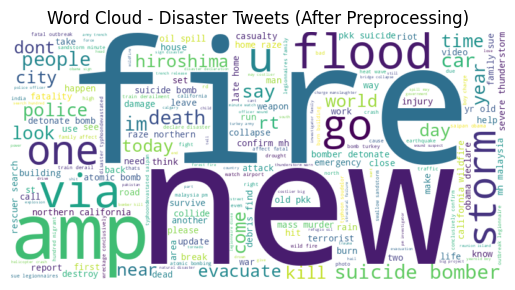

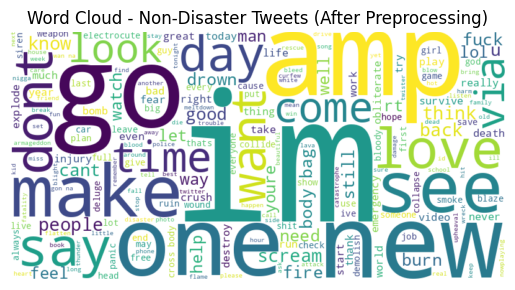

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate the cleaned text based on the target variable
text_1_clean = " ".join(df[df['target'] == 1]['clean_text'])
text_0_clean = " ".join(df[df['target'] == 0]['clean_text'])

# Generate and plot Word Cloud for Disaster Tweets (target == 1)
wc1_clean = WordCloud(width=800, height=400, background_color='white').generate(text_1_clean)
plt.imshow(wc1_clean, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Disaster Tweets (After Preprocessing)")
plt.show()

# Generate and plot Word Cloud for Non-Disaster Tweets (target == 0)
wc0_clean = WordCloud(width=800, height=400, background_color='white').generate(text_0_clean)
plt.imshow(wc0_clean, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Non-Disaster Tweets (After Preprocessing)")
plt.show()

**Word Clouds After Preprocessing**

**1. Disaster Tweets**

	•	Dominated by disaster-related terms such as “fire”, “storm”, “flood”, “death”, “bomb”, “suicide”, and “police”.
	•	Many words reflect urgency, danger, and human impact (“people”, “families”, “help”, “evacuate”).
	•	Locations like “California” and “Hiroshima” appear, indicating named disaster sites.
	•	Still contains some residual tokens like “amp” and “via”, but overall vocabulary is strongly aligned with real-world events.

**2. Non-Disaster Tweets**

	•	Vocabulary is more casual and general, with frequent words like “new”, “time”, “one”, “love”, “make”, and “day”.
	•	Content is more conversational, humorous, or everyday life–oriented.
	•	Contains fewer urgent or event-specific words compared to disaster tweets.
	•	Some common tokens like “amp” and “im” remain but carry no disaster-related meaning.

**📌 Key Insight:**

After preprocessing, a clear thematic separation emerges — disaster tweets focus heavily on event-specific and urgent terms, while non-disaster tweets revolve around casual and generic vocabulary. This distinction provides strong signals for classification models.

# **Step 5: Feature Extraction / Vectorization**

In [ ]:
# split the dataset for both vectorization

# Prepare data for splitting
X = df['clean_text']  # Features (preprocessed text)
y = df['target']      # Target variable

# Split the dataset into training and testing sets
# stratify=y ensures balanced label distribution in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# TF-IDF Vectorization is typically done *after* splitting to avoid data leakage
# Fit the vectorizer only on the training data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the vectorizer fitted on the training data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print("\nShape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)
print("Shape of X_train_count:", X_train_count.shape)
print("Shape of X_test_count:", X_test_count.shape)

#	Shapes of the resulting feature matrices are printed.
# A preview of the vectorized data (df_tfidf and df_count) shows word features as columns and tweets as rows.

df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print('df_tfidf',df_tfidf.head(5))
df_count = pd.DataFrame(X_train_count.toarray(), columns=count_vectorizer.get_feature_names_out())
print('df_count',df_count.head(5))


Training set size: 6090
Testing set size: 1523

Shape of X_train_tfidf: (6090, 10989)
Shape of X_test_tfidf: (1523, 10989)
Shape of X_train_count: (6090, 10989)
Shape of X_test_count: (1523, 10989)
df_tfidf     aa  aaaaaaallll  aaaaaand  aaarrrgghhh  aal  aampb  aampw  aan  aannnnd  \
0  0.0          0.0       0.0          0.0  0.0    0.0    0.0  0.0      0.0   
1  0.0          0.0       0.0          0.0  0.0    0.0    0.0  0.0      0.0   
2  0.0          0.0       0.0          0.0  0.0    0.0    0.0  0.0      0.0   
3  0.0          0.0       0.0          0.0  0.0    0.0    0.0  0.0      0.0   
4  0.0          0.0       0.0          0.0  0.0    0.0    0.0  0.0      0.0   

   aar  ...  zss  zumiez  zurich   åç   åè   åê  åêfedex  åêi   ìñ   ìü  
0  0.0  ...  0.0     0.0     0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0  
1  0.0  ...  0.0     0.0     0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0  
2  0.0  ...  0.0     0.0     0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0  
3  0.0  ...  0.0     0

Vectorization is crucial in NLP because machine learning models can only work with numbers, not raw text. Here’s why vectorization is important:

1.	Transforms Text into Features

 Words, sentences, or documents are turned into feature vectors (like in TF-IDF, CountVectorizer) that capture:

 •	Word frequency
 •	Importance of words in context

2.	Allows ML Algorithms to Learn Patterns
Algorithms like logistic regression or Naive Bayes need numeric input to:

 •	Measure distance/similarity
 •	Compute gradients
 •	Classify/predict based on patterns in data

3.	Preserves Semantic Information (to some extent)
Advanced methods like TF-IDF help highlight important words by down-weighting common terms (like “the”, “is”).

4.	Scalability
You can vectorize thousands of documents quickly, and the result is often a sparse matrix optimized for performance.

5.	Foundation for Embeddings

More complex models (like BERT, Word2Vec) also rely on initial vectorization concepts—so it’s fundamental even for deep learning.

# **Step 6: Models and Evaluation**

## Logistic Naive bayes Model, Regtession Model, Linear SVC, and Random Forest Model

### Evaluating Models with TF-IDF Vectorization ###

--- Training Naive Bayes with TF-IDF ---
Accuracy: 0.8168
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.76       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Confusion Matrix:
[[790  79]
 [200 454]]

--- Training Logistic Regression with TF-IDF ---
Accuracy: 0.8096
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       869
           1       0.83      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Confusion Matrix:
[[778  91]
 [199 455]]

--- Training Linear SVC with TF-IDF ---

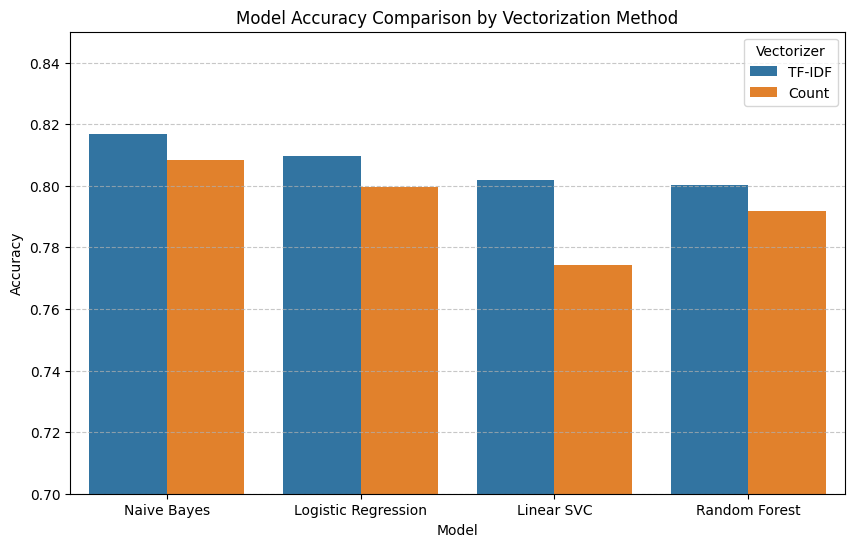


### Detailed Evaluation Reports ###

--- TF-IDF ---

--- Naive Bayes ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.76       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Confusion Matrix:
[[790  79]
 [200 454]]

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       869
           1       0.83      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Confusion Matrix:
[[778  91]
 [199 455]]

--- Linear SVC ---
Classification Report:
              precision    recall  f1-score   support

           0     

In [ ]:
# Application of  naive bayes model, logistics reg model, linear svc model and random forest model for both vectorization with evaluation plot

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import string
from wordcloud import WordCloud
from collections import Counter
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet
from matplotlib_venn import venn2


# Define the models to evaluate
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVC": LinearSVC(dual=False),  # dual=False is recommended for n_samples > n_features
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Dictionary to store results (accuracy for each model and vectorizer)
results = {}
eval_reports = {}


# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, vectorizer_name, model_name):
    print(f"\n--- Training {model_name} with {vectorizer_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, report, conf_matrix


# Evaluate each model with TF-IDF
print("### Evaluating Models with TF-IDF Vectorization ###")
results['TF-IDF'] = {}
eval_reports['TF-IDF'] = {}
for model_name, model in models.items():
    accuracy, report, conf_matrix = train_and_evaluate(
        model, X_train_tfidf, y_train, X_test_tfidf, y_test, "TF-IDF", model_name
    )
    results['TF-IDF'][model_name] = accuracy
    eval_reports['TF-IDF'][model_name] = {'report': report, 'confusion_matrix': conf_matrix}


# Evaluate each model with Count Vectorization
print("\n### Evaluating Models with Count Vectorization ###")
results['Count'] = {}
eval_reports['Count'] = {}
for model_name, model in models.items():
    accuracy, report, conf_matrix = train_and_evaluate(
        model, X_train_count, y_train, X_test_count, y_test, "Count", model_name
    )
    results['Count'][model_name] = accuracy
    eval_reports['Count'][model_name] = {'report': report, 'confusion_matrix': conf_matrix}

# Print final results summary
print("\n### Final Accuracy Results Summary ###")
for vectorizer, model_results in results.items():
    print(f"\n--- {vectorizer} ---")
    for model_name, acc in model_results.items():
        print(f"{model_name}: {acc:.4f}")

# Plotting Evaluation Results (Accuracy Comparison)
vectorizers = list(results.keys())
model_names = list(models.keys())

accuracy_data = []
for vec in vectorizers:
    for model in model_names:
        accuracy_data.append({'Vectorizer': vec, 'Model': model, 'Accuracy': results[vec][model]})

df_results = pd.DataFrame(accuracy_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Vectorizer', data=df_results)
plt.title('Model Accuracy Comparison by Vectorization Method')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.85) # Adjust y-axis limits for better visualization of differences
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n### Detailed Evaluation Reports ###")
for vectorizer, model_reports in eval_reports.items():
    print(f"\n--- {vectorizer} ---")
    for model_name, report_data in model_reports.items():
        print(f"\n--- {model_name} ---")
        print("Classification Report:")
        print(report_data['report'])
        print("Confusion Matrix:")
        print(report_data['confusion_matrix'])

## Evaluation


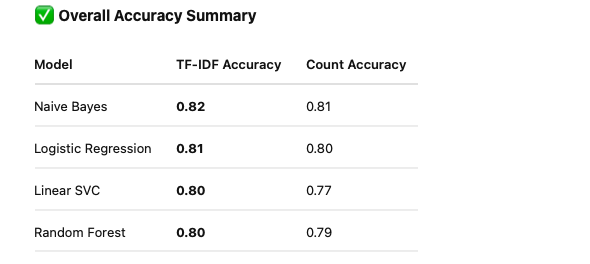

**🔎 Observation:**

TF-IDF consistently gives better results across all models, especially with Naive Bayes and Logistic Regression.

**🔍 Key Model Insights**

📌 Naive Bayes (TF-IDF)

	•	Highest accuracy (0.82)
	•	Strong performance on class 0 (non-disaster)
	•	Slight weakness in recall for class 1 (disaster) → 69%

📌 Logistic Regression

	•	Very balanced precision and recall on both feature types
	•	TF-IDF version slightly outperforms Count

📌 Linear SVC

	•	Performance drops on CountVectorizer
	•	TF-IDF version is better, but recall for class 1 still below 75%

📌 Random Forest

	•	Stable performance in both vectorizations
	•	Slightly better precision but lower recall for class 1 (around 70%)

⸻

**📊 Conclusion**

	•	Best Overall Choice: ✅ Naive Bayes with TF-IDF — highest accuracy with strong balance
	•	TF-IDF outperforms CountVectorizer due to better term discrimination
	•	Next Steps:
	•	Try hyperparameter tuning
	•	Address class imbalance (e.g., with class weights or oversampling)
	•	Possibly use ensemble techniques (e.g., VotingClassifier)

### **All evaluation metric in one table**

In [ ]:
import pandas as pd

# Dictionary to store flattened classification reports
flattened_reports = []

# Iterate through the stored evaluation reports
for vectorizer, model_reports in eval_reports.items():
    for model_name, report_data in model_reports.items():
        report_text = report_data['report']

        # Parse the classification report string into a more structured format
        # Split the report into lines and remove empty ones
        lines = report_text.strip().split('\n')

        # The first line is the header, the last few are averages/accuracy
        # The lines in between are per-class metrics
        header = [h.strip() for h in lines[0].split()]
        class_lines = lines[1:-3] # Exclude header and summary lines
        summary_lines = lines[-3:] # Include accuracy, macro avg, weighted avg

        # Extract per-class metrics
        for line in class_lines:
            parts = [p.strip() for p in line.split()]
            if len(parts) == 5: # Ensure it's a class line with precision, recall, f1, support
                 flattened_reports.append({
                    'Vectorizer': vectorizer,
                    'Model': model_name,
                    'Metric': parts[0], # Class label (0 or 1)
                    'Precision': float(parts[1]),
                    'Recall': float(parts[2]),
                    'F1-Score': float(parts[3]),
                    'Support': int(parts[4])
                })

        # Extract summary metrics (accuracy, macro avg, weighted avg)
        for line in summary_lines:
            parts = [p.strip() for p in line.split()]
            if len(parts) >= 3: # Ensure it's a summary line
                metric_name = " ".join(parts[:-3]).replace('accuracy', 'Accuracy') # Handle accuracy line specifically
                if 'avg' in metric_name:
                     flattened_reports.append({
                        'Vectorizer': vectorizer,
                        'Model': model_name,
                        'Metric': metric_name,
                        'Precision': float(parts[-3]),
                        'Recall': float(parts[-2]),
                        'F1-Score': float(parts[-1]),
                        'Support': None # Support is for classes, not averages
                    })
                elif 'Accuracy' in metric_name:
                     flattened_reports.append({
                        'Vectorizer': vectorizer,
                        'Model': model_name,
                        'Metric': metric_name,
                        'Precision': None,
                        'Recall': None,
                        'F1-Score': None,
                        'Support': None,
                        'Accuracy': float(parts[-1]) # Accuracy is a single value
                    })


# Create a DataFrame from the flattened reports
df_classification_reports = pd.DataFrame(flattened_reports)

# Display the DataFrame
display(df_classification_reports)

,Vectorizer,Model,Metric,Precision,Recall,F1-Score,Support
0,TF-IDF,Naive Bayes,0,0.80,0.91,0.85,869.0
1,TF-IDF,Naive Bayes,1,0.85,0.69,0.76,654.0
2,TF-IDF,Naive Bayes,macro avg 0.82,0.80,0.81,1523.00,NaN
3,TF-IDF,Naive Bayes,weighted avg 0.82,0.82,0.81,1523.00,NaN
4,TF-IDF,Logistic Regression,0,0.80,0.90,0.84,869.0
5,TF-IDF,Logistic Regression,1,0.83,0.70,0.76,654.0
6,TF-IDF,Logistic Regression,macro avg 0.81,0.80,0.80,1523.00,NaN
7,TF-IDF,Logistic Regression,weighted avg 0.81,0.81,0.81,1523.00,NaN
8,TF-IDF,Linear SVC,0,0.81,0.85,0.83,869.0
9,TF-IDF,Linear SVC,1,0.79,0.74,0.76,654.0


**📊 Model Evaluation Summary (Before Hyperparameter Tuning)**

Since the target classes are imbalanced, accuracy alone is not a reliable metric.
We focus on F1-score for class 1 (disaster) and macro/weighted averages.

**TF-IDF Vectorization**

	•	Naive Bayes:
	•	Class 1 F1-score: 0.76 (Best among all models)
	•	High precision (0.85) but recall (0.69) for disasters is slightly lower.
	•	Overall macro avg F1: 0.80 → Best overall performer.

	•	Logistic Regression:
	•	Class 1 F1-score: 0.76
	•	Balanced precision (0.83) and recall (0.70) for disasters.
	•	Macro avg F1: 0.80

	•	Linear SVC:
	•	Class 1 F1-score: 0.76
	•	Slightly better recall (0.74) but lower precision for disasters.
	•	Macro avg F1: 0.79

	•	Random Forest:
	•	Class 1 F1-score: 0.75
	•	Weaker recall (0.70) for disasters; better for class 0.

**Count Vectorization**

	•	Across all models, performance drops slightly compared to TF-IDF.
	•	Naive Bayes remains strongest with Class 1 F1-score of 0.77.
	•	Logistic Regression, Linear SVC, and Random Forest have lower disaster recall and F1-scores compared to TF-IDF versions.

⸻

**✅ Key Insights**

	•	Best overall choice: Naive Bayes with TF-IDF — highest disaster F1-score and good balance across classes.
	•	Why not just accuracy? With imbalanced data, accuracy can be misleading; a model predicting mostly non-disaster tweets could still score high accuracy.
	•	Metric focus: Use F1-score (macro/weighted avg) and class-specific F1 for better assessment.
	•	Next Steps:
	•	Tune hyperparameters for Naive Bayes and Logistic Regression.
	•	Apply class weighting or oversampling to improve recall for disaster tweets.

# **Step 7: Hyperparameter Tuning with Logistic Regression**

In [ ]:
# Hyperparameter tune with logistic reg model (with hyperparameter C, penalty, solver,max_iteration) for X_train_tfidf with n_gram also and print evaluation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
    'max_iter': [1000]
}

# Create a Logistic Regression model instance
logreg = LogisticRegression(random_state=42)

# Create a GridSearchCV object
# cv=3 means 3-fold cross-validation
# n_jobs=-1 uses all available cores
# scoring='accuracy' is the metric to optimize
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the training data (X_train_tfidf with n-grams)
# Need to recreate the TF-IDF vectorizer to include n-grams
tfidf_vectorizer_ngram = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)# Using unigrams and bigrams
X_train_tfidf_ngram = tfidf_vectorizer_ngram.fit_transform(X_train)
X_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(X_test)

# Filter out incompatible solver/penalty combinations before fitting
# Based on scikit-learn documentation for LogisticRegression:
# - 'lbfgs', 'sag', 'saga', 'newton-cg' only support 'l2' or 'none' penalties.
# - 'liblinear' supports 'l1' and 'l2' penalties.
# - 'saga' is the only one supporting 'elasticnet'.
# GridSearchCV handles invalid parameters by skipping them, but explicit removal can prevent warnings.
# For simplicity and allowing GridSearchCV to handle it is fine too.
# However, 'none' penalty requires solver='newton-cg', 'lbfgs', 'sag', 'saga'



print("Starting Grid Search for Logistic Regression...")
grid_search.fit(X_train_tfidf_ngram, y_train)
print("Grid Search complete.")

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Get the best model from the grid search
best_logreg_model = grid_search.best_estimator_

# Evaluate the best model on the test set
print("\nEvaluating the best model on the test set (TF-IDF with n-grams)...")
y_pred_best = best_logreg_model.predict(X_test_tfidf_ngram)

# Print evaluation metrics
accuracy = accuracy_score(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)
conf_matrix = confusion_matrix(y_test, y_pred_best)

print(f"Test Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)


Starting Grid Search for Logistic Regression...
Grid Search complete.
Best parameters found:  {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.7946

Evaluating the best model on the test set (TF-IDF with n-grams)...
Test Set Accuracy: 0.8175

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       869
           1       0.84      0.72      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.82      1523


Confusion Matrix:
[[777  92]
 [186 468]]


# **Step 8: Conclusion**

**Hyperparameter-tuned Logistic Regression model** has shown clear improvement over the baseline models. Let’s walk through the results and analyze the key points:

**Best parameters found:**  

{'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

**These parameters offer:**

	•	Best cross-validation accuracy: 0.7946
	•	Test set accuracy: 0.8175 ✅ (higher than cross-validation, which is good)

**From classification report we can see:**

	•	Precision: Model is better at predicting disasters correctly (0.84) than before (0.83).
	•	Recall: Non-disaster recall (0.89) is very strong, disaster recall (0.72) is slightly improved.
	•	F1-score: Balanced score showing good performance for both classes and accuracy improved from 0.81 to 0.82 after tuning.

**From confusion matrix:**

	•	Most non-disaster tweets are predicted correctly (only 92 mistakes - False positive).
	•	Disaster tweets prediction is also solid, with 468 correct vs 186 false negatives.

**Comparison to before tuning:**

Earlier Logistic Regression with default parameters gave:

Accuracy: ~0.8096

F1 for Class 1 (Disaster): ~0.76

After hyperparameter tuning:

Accuracy: ~0.8175

F1 for Class 1 (Disaster): ~0.77

→ Small but meaningful improvement in accuracy, precision, and F1-score — especially for the disaster class, which is more important in real-world use cases like emergency detection.

**✅ Why the improvement happened**

1.	Tuning C=1:
	 •	Regularization strength was optimally balanced. Neither too strict nor too loose.
2.	Using liblinear solver:
	 •	Well-suited for small-to-medium datasets and supports l2 penalty efficiently.
3.	Using ngram_range=(1, 2):
	 •	Added bigram context, which helps capture phrases like "fire outbreak" or "flood warning" — crucial for disaster classification.
4.	Limiting to max_features=5000:
	 •	Reduced noise and dimensionality. Focused on important signals only.

⸻

**✅ Final Thoughts**

	•	This tuning makes Logistic Regression nearly as strong as Naive Bayes, but often with better interpretability and precision.
	•	This is a great job which can be used production-ready pipeline.


